In [95]:
# import
import keras
import sys
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import model_selection
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import h5py as h5py

In [96]:
BINARY = False
timestep = 1
epochs = 10
en_corpus_file = "corpus-en.txt"
ewo_corpus_file = "corpus-ewo.txt"
best_model_file = "best-model-conll.hdfs"
max_nb_of_phrases =  -1
duplication = 1
max_depth = 0
is_only_vocab = True
shuffle = is_only_vocab
h1_size = 640
h2_size = 160

In [97]:
def getTag(aString):
    tag = "O"
    if BINARY:
        if aString != "O":
            return "NE"
    else:
        tag = aString
    return tag
     

In [98]:
def load_corpus(file, max_nb_of_phrases):
    nb_of_phrases = 0
    dataset = {"word": [], "ne-tag": []}
    with open(file) as f:
        prev_line = None
        for cpt, line in enumerate(f):
            if cpt == 0:
                continue
            if nb_of_phrases == max_nb_of_phrases:
                break;

            l = line.strip()
            if len(l) == 0 and len(prev_line) != 0:
                nb_of_phrases += 1
                dataset["word"].append(line)
                dataset["ne-tag"].append(None)
            else:
                l = l.split("\t")
                if l[0] not in string.punctuation:
                    dataset["word"].append(l[0])
                    dataset["ne-tag"].append(ne_type(l[1]))
            prev_line = line.strip()
        
    return pd.DataFrame(dataset), nb_of_phrases+1

In [99]:
def corpus_fingerprint(aDataframe, nb_of_biphrases):
    # create distributionnal signature
    fingerprints = {}
    current_bi_phrase_index = 0
    nb_word_in_corpus = aDataframe[aDataframe.word != "\n"].word.size
    words_in_current_phrase = []
    for index, row in aDataframe.iterrows():
        if current_bi_phrase_index > nb_of_biphrases:
            break
            
        word = row['word']
        
        if word != "\n":
            words_in_current_phrase.append(word)
            if word not in fingerprints:
                fingerprints[word] = np.zeros(nb_of_biphrases, dtype=np.float32)
            fingerprints[word][current_bi_phrase_index] += 1
        else:
            nb_word_in_current_phrase = len(words_in_current_phrase)
#             for w in words_in_current_phrase:
#                 fingerprints[w][current_bi_phrase_index] = nb_word_in_corpus / fingerprints[w][current_bi_phrase_index]                
            current_bi_phrase_index += 1
            words_in_current_phrase = []
    for word in fingerprints:
        for i in range(nb_of_biphrases):
            if fingerprints[word][i] != 0:
                fingerprints[word][i] = nb_word_in_corpus / fingerprints[word][i]
#         fingerprints[word][nb_of_biphrases] = nb_word_in_corpus / aDataframe[aDataframe.word == word].word.size
        
    return pd.DataFrame(fingerprints)

In [100]:
def corpus2trainingdata(aDataframe, fingerprintsDataFrame):
    X = np.zeros((aDataframe.shape[0], fingerprintsDataFrame.shape[0]), dtype=np.int8)
    y = np.zeros(aDataframe.shape[0], dtype=np.int8)
    i = 0
    for row in aDataframe.iterrows():
        X[i] = fingerprintsDataFrame[row[1]['word']].values
        y[i] = tag2int[getTag(row[1]['ne-tag'])]
        i += 1
    return X, y

In [101]:
def train_test_split(X, y, test_size = 0.33):
    total = X.shape[0]
    train_length = round(total * (1 - test_size)) 
    return X[:train_length], X[train_length:], y[:train_length], y[train_length:]

In [102]:
  
def ne_type(aType):
    aType = aType.lower()
    if 'per' in aType:
        t =  'NE' if BINARY else 'PER' 
    elif 'loc' in aType:
        t =  'NE' if BINARY else 'LOC'
    elif 'org' in aType:
        t =  'NE' if BINARY else 'ORG'
    elif 'hour' in aType:
        t =  'NE' if BINARY else 'MISC'
    elif aType != 'o' and len(aType) > 0 :
        t =  'NE' if BINARY else 'MISC'
    else:
        t = 'O'
    return t

In [103]:
def compute_performance(y_true, y_pred, words=None, BINARY=False):
    if BINARY:
        p = precision_score(y_true, y_pred, pos_label=tag2int['NE'])
        r = recall_score(y_true, y_pred, pos_label=tag2int['NE'])
        f1 = f1_score(y_true, y_pred, pos_label=tag2int['NE'])
        acc = accuracy_score(y_true, y_pred)
    else:
        p = precision_score(y_pred, y_true, average='macro')
        r = recall_score(y_pred, y_true, average='macro')
        f1 = f1_score(y_pred, y_true, average='macro')
        acc = accuracy_score(y_pred, y_true)
    if words is None:
        model_output_vs = pd.DataFrame({'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})
    else:
        model_output_vs = pd.DataFrame({'word': words, 'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})

    return p, r, f1, acc, model_output_vs

In [104]:
def P_R_F1(y_pred, y_true, neg_class):
    same = y_pred[y_true==y_pred]
    tp = same[same != neg_class].size
    nb_of_pos_exple = y_true[y_true != neg_class].size
    nb_of_pos_pred = y_pred[y_pred != neg_class].size
    p = r = f1 = 0
    try:
        p = np.round(tp*100/nb_of_pos_pred, 2)
    except ZeroDivisionError:
        print("number of correct positive predictions is 0")
        
    try:
        r = np.round(tp*100/nb_of_pos_exple, 2)
    except ZeroDivisionError:
        print("number of position exple is 0")
        
    try:
        f1 = np.round(2*r*p/(r+p), 2)
    except ZeroDivisionError:
        print("Recall and precision are 0")

    return p, r, f1

In [105]:
def is_mergeable(aListOfConsecutiveTokens, corpus, fingerprints):
    n = len(aListOfConsecutiveTokens)
    if n <= 1:
        return False
    if n == 2:
        w1, w2 = aListOfConsecutiveTokens[0], aListOfConsecutiveTokens[1]
        rep1, rep2 = fingerprints[aListOfConsecutiveTokens[0]], fingerprints[aListOfConsecutiveTokens[1]]
        tag1, tag2 = corpus[corpus.word==w1].iloc[0]['ne-tag'], corpus[corpus.word==w2].iloc[0]['ne-tag']
        if (tag1 == tag2) and (tag1 == "O"): # O + O => False
            return False
        if (tag1 != tag2) and (tag1 != "O") and (tag2 != "O"): # X + Y => False
            return False
        return rep1.equals(rep2)
    else:
        half = int(n / 2)
        return is_mergeable(aListOfConsecutiveTokens[0:half+1], corpus, fingerprints) and is_mergeable(aListOfConsecutiveTokens[half:n], corpus, fingerprints)

In [106]:
def merge(depth, corpus, fingerprint):
    wordDf = corpus[corpus.word != "\n"].word
    nbOfWord = wordDf.shape[0]
    text = list(wordDf)
    X2, target2, tokens = [], [], []
    level, newToken = 1, True
    while level <= depth and newToken:
        i, newToken = 0, False
        limit = nbOfWord - level
        while i < limit:
            if is_mergeable(text[i:i+level+1], corpus, fingerprint):
                tokens.append(" ".join(text[i:i+level+1]))
                newToken = True
            i += 1
        print("level ", level, ":", set(tokens))
        level += 1
    
    X2, target2 = np.array(X2), np.array(target2)
    
    return X2, target2, set(tokens)

In [107]:
def shuffle(X, y):
    indices = [i for i in  range(X.shape[0])]
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [108]:
def create_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(h1_size, input_dim=input_dim, activation='sigmoid', name="hidden1"))
    model.add(Dense(h2_size, activation='sigmoid', name="hidden2"))
    if BINARY:
        model.add(Dense(1, activation='sigmoid', name="outputlayer"))
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
    else:
        model.add(Dense(output_dim, activation='softmax', name="outputlayer"))
        model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    model.summary()
    return model

In [109]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=epochs):
    early_stop = EarlyStopping(patience=20, verbose=2) # stop learning if the error is the same between two consecutive epochs
    best_model_cp = ModelCheckpoint(best_model_file, save_best_only=True, verbose=1) # saved best model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0, shuffle=shuffle, callbacks=[best_model_cp, early_stop])
    best_model = keras.models.load_model(best_model_file) #loading the best model
    return best_model

In [110]:
def predict(model, X, y, binary=BINARY):
    if BINARY:
        y_pred = np.round(model.predict(X))
        y_true = y
    else:
        predictions = model.predict(X)
        y_pred = np.array([np.argmax(p) for p in predictions])
        y_true = np.array([np.argmax(t) for t in y ])
    return y_true, y_pred

In [111]:
def model_performance(y_true, y_pred):
    return P_R_F1(y_pred, y_true, tag2int['O']) #precision, recall, f1-score

In [112]:
def model_performace_by_tag(y_true, y_pred, tag):
    p, r, f1 = 0, 0, 0
    
    eq = y_pred[y_pred==y_true]
    correctly_pred = eq[eq==tag].size
    try:
        p = np.round(100 * correctly_pred / y_pred[y_pred==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        r = np.round(100 * correctly_pred / y_true[y_true==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        f1 = np.round(2 * r * p / (r + p), 2)
    except ZeroDivisionError:
        pass
    
    return p, r, f1

In [113]:
def algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, epochs=epochs, model=None):
    test_precision, train_precision, ewo_precision = [], [], []
    test_recall, train_recall, ewo_recall = [], [], []
    test_fscore, train_fscore, ewo_fscore = [], [], []
    
    test_result_by_tag = {}
    train_result_by_tag = {}
    ewo_result_by_tag = {}
    for t in tagSet:
        f1_key = "F1-"+t
        p_key = "P-"+t
        r_key = "R-"+t
        train_result_by_tag[f1_key], train_result_by_tag[p_key], train_result_by_tag[r_key] = [], [], []
        test_result_by_tag[f1_key], test_result_by_tag[p_key], test_result_by_tag[r_key] = [], [], []
        ewo_result_by_tag[f1_key], ewo_result_by_tag[p_key], ewo_result_by_tag[r_key] = [], [], []

    m = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
    y_true, y_pred = predict(m, X_train, y_train)
    p_train, r_train, f1_train = model_performance(y_true, y_pred)
        
    y_true_val, y_pred_val = predict(m, X_val, y_val)
    p_val, r_val, f1_val = model_performance(y_true_val, y_pred_val)
        
    y_true_ewo, y_pred_ewo = predict(m, X_ewo, y_ewo) 
    p_ewo, r_ewo, f1_ewo = model_performance(y_true_ewo, y_pred_ewo)
        
    for t in range(len(int2tag)):
        f1_key = "F1-" + int2tag[t]
        p_key = "P-" + int2tag[t]
        r_key = "R-" + int2tag[t]
            
        p, r, f1 = model_performace_by_tag(y_true, y_pred, t)
        train_result_by_tag[p_key].append(p)
        train_result_by_tag[r_key].append(r)
        train_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_val, y_pred_val, t)
        test_result_by_tag[p_key].append(p)
        test_result_by_tag[r_key].append(r)
        test_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_ewo, y_pred_ewo, t)
        ewo_result_by_tag[p_key].append(p)
        ewo_result_by_tag[r_key].append(r)
        ewo_result_by_tag[f1_key].append(f1)
                
    test_precision.append(p_val)
    train_precision.append(p_train)
    ewo_precision.append(p_ewo)
        
    test_recall.append(r_val)
    train_recall.append(r_train)
    ewo_recall.append(r_ewo)
        
    test_fscore.append(f1_val)
    train_fscore.append(f1_train)
    ewo_fscore.append(f1_ewo)
    return pd.DataFrame({
        'P_test': test_precision, 
        'P_train': train_precision, 
        'P_ewo': ewo_precision, 'R_test': test_recall, 'R_train': train_recall, 
        'R_ewo': ewo_recall, 'F1-test': test_fscore, 'F1-train': train_fscore, 'F1-ewo': ewo_fscore}), pd.DataFrame(train_result_by_tag), pd.DataFrame(test_result_by_tag), pd.DataFrame(ewo_result_by_tag)

In [114]:
def algoCrossVal(X, y, X_ewo, y_ewo, k = 10, repeat=1): 
    block_size = int(X.shape[0] / k)   
    output = None
    model = None
    train_by_tags, test_by_tags, ewo_by_tags = None, None, None
    for it in range(repeat):
        print("AlgoCrossValIter -", it+1)
        model = create_model(X.shape[1], len(tagSet))
        results = None
        train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = None, None, None
        for i in range(k):
            X_val, y_val = X[i*block_size:i*block_size+block_size], y[i*block_size:i*block_size+block_size]
            X_train = np.concatenate((X[0:i*block_size], X[i*block_size+block_size:]))
            y_train = np.concatenate((y[0:i*block_size], y[i*block_size+block_size:]))

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

            result, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)
            if results is None:
                results = result.copy()
                train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = train_by_tag.copy(), test_by_tag.copy(), ewo_by_tag.copy()
            else:
                results = pd.concat([results, result], ignore_index=True)
                train_by_tagsTmp = pd.concat([train_by_tagsTmp, train_by_tag], ignore_index=True)
                test_by_tagsTmp = pd.concat([test_by_tagsTmp, test_by_tag], ignore_index=True)
                ewo_by_tagsTmp = pd.concat([ewo_by_tagsTmp, ewo_by_tag], ignore_index=True)
        
        if output is None:
            output = results.mean(axis=0).to_frame()
            train_by_tags = train_by_tagsTmp.mean(axis=0).to_frame()
            test_by_tags = test_by_tagsTmp.mean(axis=0).to_frame()
            ewo_by_tags = ewo_by_tagsTmp.mean(axis=0).to_frame()
        else:
            output = pd.concat([output, results.mean(axis=0).to_frame()], axis=1)
            train_by_tags = pd.concat([train_by_tags, train_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            test_by_tags = pd.concat([test_by_tags, test_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            ewo_by_tags = pd.concat([ewo_by_tags, ewo_by_tagsTmp.mean(axis=0).to_frame()], axis=1)

    return output, train_by_tags, test_by_tags, ewo_by_tags, model

In [115]:
en_corpus, en_nb_of_phrases = load_corpus(en_corpus_file, max_nb_of_phrases)

In [116]:
en_corpus.head()
en_corpus.loc[en_corpus['ne-tag'] == 'ORG']

,word,ne-tag
1335,Sadducees,ORG


In [117]:
tagSet = en_corpus["ne-tag"].dropna().unique()
if BINARY:
    tagSet = ['NE', 'O']
tag2int = {j: i for i, j in enumerate(tagSet)}
int2tag = {i: j for i, j in enumerate(tagSet)}
print(tag2int)

{'O': 0, 'MISC': 1, 'PER': 2, 'LOC': 3, 'ORG': 4}


In [118]:
en_nb_of_phrases

210

In [119]:
en_corpus.describe()

,word,ne-tag
count,4379,4170
unique,904,5
top,the,O
freq,313,3779


In [120]:
en_corpus.head(10)

,word,ne-tag
0,The,O
1,Promise,O
2,of,O
3,the,O
4,Holy,MISC
5,Spirit,MISC
6,\n,None
7,In,O
8,the,O
9,first,O


In [121]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 86.3 %
MISC % = 2.4 %
PER % = 5.59 %
LOC % = 0.91 %
ORG % = 0.02 %


In [122]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.16 %
MISC % = 1.88 %
PER % = 8.96 %
LOC % = 1.99 %
ORG % = 0.11 %


In [123]:
en_corpus[en_corpus.word == "\n"].shape

(209, 2)

In [124]:
print("Nb of bi-phrases", en_nb_of_phrases)
en_fingerprints = corpus_fingerprint(en_corpus, en_nb_of_phrases)

Nb of bi-phrases 210


In [125]:
en_fingerprints.head(5)

,The,Promise,of,the,Holy,Spirit,In,first,book,O,...,considered,dream,She,save,fulfill,Immanuel,us),woke,sleep,knew
0,4170.0,4170.0,4170.0,4170.0,4170.0,4170.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,4170.0,0.0,0.0,4170.0,4170.0,4170.0,4170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1390.0,4170.0,4170.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4170.0,4170.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4170.0,2085.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
en_fingerprints['you'].values.shape

(210,)

In [127]:
en_corpus[en_corpus.word != "\n"].shape

(4170, 2)

In [128]:
X2, target2, tokens = merge(max_depth, en_corpus, en_fingerprints)

In [129]:
if is_only_vocab:
    text = list(en_corpus[en_corpus.word != "\n"].word.unique())
else:
    text = list(en_corpus[en_corpus.word != "\n"].word)
en_vocab = pd.DataFrame({'text': text + list(tokens)})
en_vocab.describe()

,text
count,903
unique,903
top,ankles
freq,1


In [130]:
if is_only_vocab:
    X = np.zeros((en_vocab.shape[0] * duplication, en_nb_of_phrases))
    target = np.zeros((en_vocab.shape[0] * duplication))
    p=0
    for i, row in en_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X[p] = en_fingerprints[c.split(" ")[0]]
            target[p] = tag2int[getTag(en_corpus[en_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X, target = shuffle(X, target)
    print(X.shape, en_fingerprints.shape, target.shape)

(903, 210) (210, 903) (903,)


In [131]:
en_vocab[-20:]

,text
883,Eliud
884,Eleazar
885,Matthan
886,husband
887,fourteen
888,unwilling
889,shame
890,resolved
891,divorce
892,quietly


In [132]:
if not is_only_vocab:
    X, target = corpus2trainingdata(en_corpus[en_corpus.word != "\n"], en_fingerprints)

In [133]:
print(X.shape, target.shape)
if len(X.shape) == len(X2.shape):
    X = np.concatenate((X, X2))
    target = np.concatenate((target, target2))
    if shuffle:
        X, target = shuffle(X, target)
print(X.shape, target.shape)

(903, 210) (903,)
(903, 210) (903,)


In [134]:
y = target.copy()
y[0:100]
if not BINARY:
    y = np_utils.to_categorical(y, len(tagSet))
y.shape

(903, 5)

In [135]:
from sklearn.decomposition import PCA

def visualize(X, y):
    pca = PCA(n_components=2)
    X_embeded = pca.fit_transform(X)
    plt.figure(figsize=(16, 16))
    plt.scatter(X_embeded[:, 0], X_embeded[:, 1], c=y)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


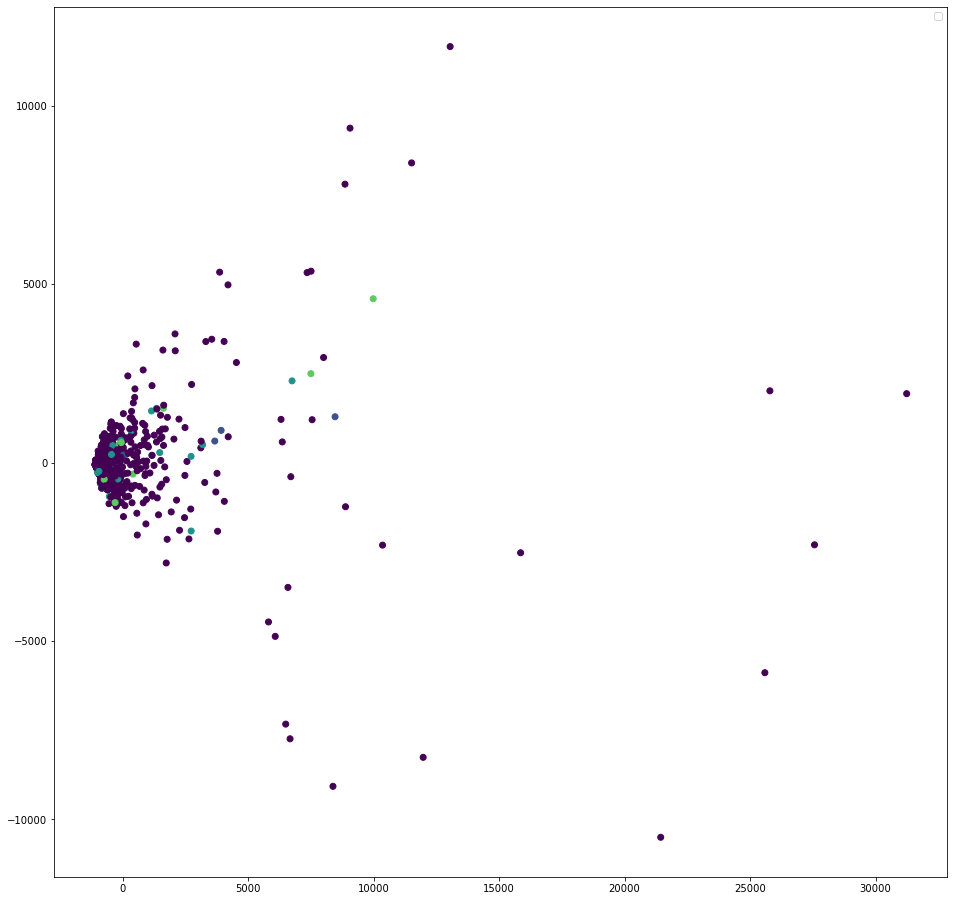

In [136]:
visualize(X, target)

In [137]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.33)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_val.shape =", X_val.shape)
print("y_val.shape =", y_val.shape)

tTarget = np.array([np.argmax(yy) for yy in y_train])
vTarget = np.array([np.argmax(yy) for yy in y_val])

for tag in tagSet:
    print("{0} % in training data = {1} %".format(tag, np.round(tTarget[tTarget==tag2int[tag]].size * 100 / tTarget.shape[0], 2)))
    print("{0} % in validation data = {1} %".format(tag, np.round(vTarget[vTarget==tag2int[tag]].size * 100 / vTarget.shape[0], 2)))

X_train.shape = (605, 210)
y_train.shape = (605, 5)
X_val.shape = (298, 210)
y_val.shape = (298, 5)
O % in training data = 87.93 %
O % in validation data = 88.93 %
MISC % in training data = 1.65 %
MISC % in validation data = 0.34 %
PER % in training data = 8.1 %
PER % in validation data = 9.4 %
LOC % in training data = 2.15 %
LOC % in validation data = 1.34 %
ORG % in training data = 0.17 %
ORG % in validation data = 0.0 %


In [138]:
ewo_corpus, ewo_nb_of_phrases = load_corpus(ewo_corpus_file, max_nb_of_phrases)

In [139]:
ewo_corpus.loc[ewo_corpus['ne-tag'] == 'PER']

,word,ne-tag
6,Teofil,PER
15,Yesus,PER
86,Yohannes,PER
104,Yesus,PER
230,Yesus,PER
...,...,...
3676,Maria,PER
3697,Yesus,PER
3740,Emmanuel,PER
3750,Yosef,PER


In [140]:
ewo_nb_of_phrases

210

In [141]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 84.15 %
MISC % = 2.54 %
PER % = 6.69 %
LOC % = 1.03 %
ORG % = 0.05 %


In [142]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.94 %
MISC % = 1.17 %
PER % = 8.3 %
LOC % = 1.86 %
ORG % = 0.2 %


In [143]:
ewo_corpus.describe()

,word,ne-tag
count,3779,3570
unique,1024,5
top,\n,O
freq,209,3180


In [144]:
ewo_corpus.head()

,word,ne-tag
0,Mfufub,MISC
1,Nsisim,MISC
2,ayi,O
3,sò,O
4,\n,None


In [145]:
ewo_fingerprints = corpus_fingerprint(ewo_corpus, en_nb_of_phrases)
# ewo_fingerprints = scale(ewo_fingerprints)

In [146]:
X2, target2, tokens = merge(max_depth, ewo_corpus, ewo_fingerprints)

In [147]:
if is_only_vocab:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word.unique())
else:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word)
ewo_vocab = pd.DataFrame({"text":text + list(tokens)})

In [148]:
if is_only_vocab:
    X_ewo = np.zeros((ewo_vocab.shape[0] * duplication, en_nb_of_phrases))
    ewo_target = np.zeros((ewo_vocab.shape[0] * duplication))
    p=0
    for i, row in ewo_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X_ewo[p] = ewo_fingerprints[c.split(" ")[0]]
            ewo_target[p] = tag2int[getTag(ewo_corpus[ewo_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X_ewo, ewo_target = shuffle(X_ewo, ewo_target)

In [149]:
ewo_vocab[-20:]

,text
1003,nlo
1004,obë
1005,mbara
1006,yabyali
1007,dzili
1008,yasò
1009,oyolëge
1010,kode
1011,dili
1012,atoban


In [150]:
if not is_only_vocab:
    X_ewo, ewo_target = corpus2trainingdata(ewo_corpus[ewo_corpus.word != "\n"], ewo_fingerprints)

In [151]:
print(X_ewo.shape, ewo_target.shape)
if len(X_ewo.shape) == len(X2.shape):
    X_ewo = np.concatenate((X_ewo, X2))
    ewo_target = np.concatenate((ewo_target, target2))
    if shuffle:
        X_ewo, ewo_target = shuffle(X_ewo, ewo_target)
print(X_ewo.shape, ewo_target.shape)

(1023, 210) (1023,)
(1023, 210) (1023,)


In [152]:
y_ewo = ewo_target.copy()
print(y_ewo.shape, len(ewo_vocab))

(1023,) 1023


In [153]:
X_ewo.shape

(1023, 210)

In [154]:
y_ewo = ewo_target.copy()
y_ewo[:20]
if not BINARY:
    y_ewo = np_utils.to_categorical(y_ewo)

In [155]:
X_ewo = X_ewo.reshape((X_ewo.shape[0], en_nb_of_phrases))

In [156]:
# model = create_model(X.shape[1], len(tagSet))
# resultEval, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)

In [157]:
# resultEval

In [158]:
# train_by_tag

In [159]:
# test_by_tag

In [160]:
# ewo_by_tag

In [161]:
# resultEval.mean()

In [162]:
# resultEval.std()

In [163]:
resultCrossVal, trainByTagResult, testByTagResult, ewoByTagResult, model = algoCrossVal(X, y, X_ewo, y_ewo, repeat=10)

AlgoCrossValIter - 1
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.43207, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.43207 to 0.42395, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.42395 to 0.41322, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.41322

Epoch 00005: val_loss 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.29256, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.29256 to 0.21055, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.21055

Epoch 00004: val_loss did not improve from 0.21055

Epoch 00005: val_loss did not improve from 0.21055

Epoch 00006: val_loss did not improve from 0.21055

Epoch 00007: val_loss did not improve from 0.21055

Epoch 00008: val_loss did not improve from 0.21055

Epoch 00009: val_loss improved from 0.21055 to 0.19946, saving model to best-model-conll.hdfs

Epoch 00010: val_loss did not improve from 0.19946


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08170, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08170

Epoch 00003: val_loss did not improve from 0.08170

Epoch 00004: val_loss did not improve from 0.08170

Epoch 00005: val_loss did not improve from 0.08170

Epoch 00006: val_loss did not improve from 0.08170

Epoch 00007: val_loss did not improve from 0.08170

Epoch 00008: val_loss did not improve from 0.08170

Epoch 00009: val_loss did not improve from 0.08170

Epoch 00010: val_loss did not improve from 0.08170


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.04106, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.04106

Epoch 00003: val_loss did not improve from 0.04106

Epoch 00004: val_loss did not improve from 0.04106

Epoch 00005: val_loss did not improve from 0.04106

Epoch 00006: val_loss did not improve from 0.04106

Epoch 00007: val_loss did not improve from 0.04106

Epoch 00008: val_loss did not improve from 0.04106

Epoch 00009: val_loss did not improve from 0.04106

Epoch 00010: val_loss did not improve from 0.04106


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10479, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.10479 to 0.09295, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.09295

Epoch 00004: val_loss did not improve from 0.09295

Epoch 00005: val_loss did not improve from 0.09295

Epoch 00006: val_loss did not improve from 0.09295

Epoch 00007: val_loss did not improve from 0.09295

Epoch 00008: val_loss did not improve from 0.09295

Epoch 00009: val_loss did not improve from 0.09295

Epoch 00010: val_loss did not improve from 0.09295


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06284, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06284

Epoch 00003: val_loss did not improve from 0.06284

Epoch 00004: val_loss did not improve from 0.06284

Epoch 00005: val_loss did not improve from 0.06284

Epoch 00006: val_loss did not improve from 0.06284

Epoch 00007: val_loss did not improve from 0.06284

Epoch 00008: val_loss did not improve from 0.06284

Epoch 00009: val_loss did not improve from 0.06284

Epoch 00010: val_loss did not improve from 0.06284

Epoch 00001: val_loss improved from inf to 0.14826, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.14826 to 0.09965, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.09965 to 0.08594, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.08594

Epoch 00005: val_loss did not improve from 0.08594

Epoch 00006: val_loss did not improve from 0.08594

Epo

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10457, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.10457 to 0.06795, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.06795 to 0.06787, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.06787

Epoch 00005: val_loss did not improve from 0.06787

Epoch 00006: val_loss did not improve from 0.06787

Epoch 00007: val_loss did not improve from 0.06787

Epoch 00008: val_loss did not improve from 0.06787

Epoch 00009: val_loss did not improve from 0.06787

Epoch 00010: val_loss did not improve from 0.06787


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 2
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.46661, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.46661

Epoch 00003: val_loss improved from 0.46661 to 0.42855, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.42855 to 0.40420, saving model to best-model-conll.hdfs

Epoch 00005: val_loss 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.16687, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.16687 to 0.15985, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.15985

Epoch 00004: val_loss did not improve from 0.15985

Epoch 00005: val_loss improved from 0.15985 to 0.15759, saving model to best-model-conll.hdfs

Epoch 00006: val_loss did not improve from 0.15759

Epoch 00007: val_loss did not improve from 0.15759

Epoch 00008: val_loss did not improve from 0.15759

Epoch 00009: val_loss did not improve from 0.15759

Epoch 00010: val_loss did not improve from 0.15759


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12063, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.12063 to 0.11413, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.11413 to 0.07712, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.07712

Epoch 00005: val_loss did not improve from 0.07712

Epoch 00006: val_loss did not improve from 0.07712

Epoch 00007: val_loss did not improve from 0.07712

Epoch 00008: val_loss did not improve from 0.07712

Epoch 00009: val_loss did not improve from 0.07712

Epoch 00010: val_loss did not improve from 0.07712

Epoch 00001: val_loss improved from inf to 0.16143, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.16143 to 0.04858, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.04858

Epoch 00004: val_loss did not improve from 0.04858

Epoch 00005: val_loss did not improve from 0.04858

Epoch 00006:

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08756, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08756

Epoch 00003: val_loss did not improve from 0.08756

Epoch 00004: val_loss did not improve from 0.08756

Epoch 00005: val_loss did not improve from 0.08756

Epoch 00006: val_loss did not improve from 0.08756

Epoch 00007: val_loss did not improve from 0.08756

Epoch 00008: val_loss did not improve from 0.08756

Epoch 00009: val_loss did not improve from 0.08756

Epoch 00010: val_loss did not improve from 0.08756


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05516, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05516

Epoch 00003: val_loss did not improve from 0.05516

Epoch 00004: val_loss did not improve from 0.05516

Epoch 00005: val_loss did not improve from 0.05516

Epoch 00006: val_loss did not improve from 0.05516

Epoch 00007: val_loss did not improve from 0.05516

Epoch 00008: val_loss did not improve from 0.05516

Epoch 00009: val_loss did not improve from 0.05516

Epoch 00010: val_loss did not improve from 0.05516


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08673, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08673

Epoch 00003: val_loss did not improve from 0.08673

Epoch 00004: val_loss did not improve from 0.08673

Epoch 00005: val_loss did not improve from 0.08673

Epoch 00006: val_loss did not improve from 0.08673

Epoch 00007: val_loss did not improve from 0.08673

Epoch 00008: val_loss did not improve from 0.08673

Epoch 00009: val_loss did not improve from 0.08673

Epoch 00010: val_loss did not improve from 0.08673

Epoch 00001: val_loss improved from inf to 0.05515, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05515

Epoch 00003: val_loss did not improve from 0.05515

Epoch 00004: val_loss did not improve from 0.05515

Epoch 00005: val_loss did not improve from 0.05515

Epoch 00006: val_loss did not improve from 0.05515

Epoch 00007: val_loss did not improve from 0.05515

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07657, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07657

Epoch 00003: val_loss improved from 0.07657 to 0.07143, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.07143

Epoch 00005: val_loss did not improve from 0.07143

Epoch 00006: val_loss did not improve from 0.07143

Epoch 00007: val_loss did not improve from 0.07143

Epoch 00008: val_loss did not improve from 0.07143

Epoch 00009: val_loss did not improve from 0.07143

Epoch 00010: val_loss did not improve from 0.07143


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 3
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.42835, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.42835 to 0.42103, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.42103 to 0.41373, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.41373

Epoch 00005: val_loss 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.14430, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.14430

Epoch 00003: val_loss did not improve from 0.14430

Epoch 00004: val_loss did not improve from 0.14430

Epoch 00005: val_loss did not improve from 0.14430

Epoch 00006: val_loss did not improve from 0.14430

Epoch 00007: val_loss did not improve from 0.14430

Epoch 00008: val_loss did not improve from 0.14430

Epoch 00009: val_loss did not improve from 0.14430

Epoch 00010: val_loss did not improve from 0.14430


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06664, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06664

Epoch 00003: val_loss did not improve from 0.06664

Epoch 00004: val_loss did not improve from 0.06664

Epoch 00005: val_loss did not improve from 0.06664

Epoch 00006: val_loss did not improve from 0.06664

Epoch 00007: val_loss did not improve from 0.06664

Epoch 00008: val_loss did not improve from 0.06664

Epoch 00009: val_loss did not improve from 0.06664

Epoch 00010: val_loss did not improve from 0.06664


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.03679, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.03679

Epoch 00003: val_loss did not improve from 0.03679

Epoch 00004: val_loss did not improve from 0.03679

Epoch 00005: val_loss did not improve from 0.03679

Epoch 00006: val_loss did not improve from 0.03679

Epoch 00007: val_loss did not improve from 0.03679

Epoch 00008: val_loss did not improve from 0.03679

Epoch 00009: val_loss did not improve from 0.03679

Epoch 00010: val_loss did not improve from 0.03679


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09432, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09432

Epoch 00003: val_loss did not improve from 0.09432

Epoch 00004: val_loss improved from 0.09432 to 0.09345, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.09345

Epoch 00006: val_loss did not improve from 0.09345

Epoch 00007: val_loss did not improve from 0.09345

Epoch 00008: val_loss did not improve from 0.09345

Epoch 00009: val_loss did not improve from 0.09345

Epoch 00010: val_loss did not improve from 0.09345


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06754, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06754

Epoch 00003: val_loss did not improve from 0.06754

Epoch 00004: val_loss did not improve from 0.06754

Epoch 00005: val_loss did not improve from 0.06754

Epoch 00006: val_loss did not improve from 0.06754

Epoch 00007: val_loss did not improve from 0.06754

Epoch 00008: val_loss did not improve from 0.06754

Epoch 00009: val_loss did not improve from 0.06754

Epoch 00010: val_loss did not improve from 0.06754


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07572, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07572

Epoch 00003: val_loss did not improve from 0.07572

Epoch 00004: val_loss did not improve from 0.07572

Epoch 00005: val_loss did not improve from 0.07572

Epoch 00006: val_loss did not improve from 0.07572

Epoch 00007: val_loss did not improve from 0.07572

Epoch 00008: val_loss did not improve from 0.07572

Epoch 00009: val_loss did not improve from 0.07572

Epoch 00010: val_loss did not improve from 0.07572

Epoch 00001: val_loss improved from inf to 0.05671, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05671

Epoch 00003: val_loss did not improve from 0.05671

Epoch 00004: val_loss did not improve from 0.05671

Epoch 00005: val_loss did not improve from 0.05671

Epoch 00006: val_loss did not improve from 0.05671

Epoch 00007: val_loss did not improve from 0.05671

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06164, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06164

Epoch 00003: val_loss did not improve from 0.06164

Epoch 00004: val_loss did not improve from 0.06164

Epoch 00005: val_loss did not improve from 0.06164

Epoch 00006: val_loss did not improve from 0.06164

Epoch 00007: val_loss did not improve from 0.06164

Epoch 00008: val_loss did not improve from 0.06164

Epoch 00009: val_loss did not improve from 0.06164

Epoch 00010: val_loss did not improve from 0.06164


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 4
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.49307, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.49307 to 0.38290, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.38290 to 0.37692, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.37692

Epoch 00005: val_loss 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.14023, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.14023

Epoch 00003: val_loss did not improve from 0.14023

Epoch 00004: val_loss did not improve from 0.14023

Epoch 00005: val_loss did not improve from 0.14023

Epoch 00006: val_loss did not improve from 0.14023

Epoch 00007: val_loss did not improve from 0.14023

Epoch 00008: val_loss did not improve from 0.14023

Epoch 00009: val_loss did not improve from 0.14023

Epoch 00010: val_loss did not improve from 0.14023


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07420, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07420

Epoch 00003: val_loss did not improve from 0.07420

Epoch 00004: val_loss did not improve from 0.07420

Epoch 00005: val_loss did not improve from 0.07420

Epoch 00006: val_loss did not improve from 0.07420

Epoch 00007: val_loss did not improve from 0.07420

Epoch 00008: val_loss did not improve from 0.07420

Epoch 00009: val_loss did not improve from 0.07420

Epoch 00010: val_loss did not improve from 0.07420

Epoch 00001: val_loss improved from inf to 0.05310, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05310

Epoch 00003: val_loss did not improve from 0.05310

Epoch 00004: val_loss did not improve from 0.05310

Epoch 00005: val_loss did not improve from 0.05310

Epoch 00006: val_loss did not improve from 0.05310

Epoch 00007: val_loss did not improve from 0.05310

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09873, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09873

Epoch 00003: val_loss improved from 0.09873 to 0.09158, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.09158

Epoch 00005: val_loss did not improve from 0.09158

Epoch 00006: val_loss did not improve from 0.09158

Epoch 00007: val_loss did not improve from 0.09158

Epoch 00008: val_loss did not improve from 0.09158

Epoch 00009: val_loss did not improve from 0.09158

Epoch 00010: val_loss did not improve from 0.09158


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08254, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.08254 to 0.06597, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.06597

Epoch 00004: val_loss did not improve from 0.06597

Epoch 00005: val_loss did not improve from 0.06597

Epoch 00006: val_loss did not improve from 0.06597

Epoch 00007: val_loss did not improve from 0.06597

Epoch 00008: val_loss did not improve from 0.06597

Epoch 00009: val_loss did not improve from 0.06597

Epoch 00010: val_loss did not improve from 0.06597


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08720, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08720

Epoch 00003: val_loss improved from 0.08720 to 0.06731, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.06731

Epoch 00005: val_loss did not improve from 0.06731

Epoch 00006: val_loss did not improve from 0.06731

Epoch 00007: val_loss did not improve from 0.06731

Epoch 00008: val_loss did not improve from 0.06731

Epoch 00009: val_loss did not improve from 0.06731

Epoch 00010: val_loss did not improve from 0.06731

Epoch 00001: val_loss improved from inf to 0.05277, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05277

Epoch 00003: val_loss did not improve from 0.05277

Epoch 00004: val_loss did not improve from 0.05277

Epoch 00005: val_loss did not improve from 0.05277

Epoch 00006: val_loss did not improve from 0.05277

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05926, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05926

Epoch 00003: val_loss did not improve from 0.05926

Epoch 00004: val_loss did not improve from 0.05926

Epoch 00005: val_loss did not improve from 0.05926

Epoch 00006: val_loss did not improve from 0.05926

Epoch 00007: val_loss did not improve from 0.05926

Epoch 00008: val_loss did not improve from 0.05926

Epoch 00009: val_loss did not improve from 0.05926

Epoch 00010: val_loss did not improve from 0.05926


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 5
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.43570, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.43570

Epoch 00003: val_loss improved from 0.43570 to 0.42514, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.42514

Epoch 00005: val_loss did not improve from 0.42514

Epoch 00006: 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12717, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.12717

Epoch 00003: val_loss did not improve from 0.12717

Epoch 00004: val_loss did not improve from 0.12717

Epoch 00005: val_loss did not improve from 0.12717

Epoch 00006: val_loss did not improve from 0.12717

Epoch 00007: val_loss did not improve from 0.12717

Epoch 00008: val_loss did not improve from 0.12717

Epoch 00009: val_loss did not improve from 0.12717

Epoch 00010: val_loss did not improve from 0.12717


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08346, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08346

Epoch 00003: val_loss did not improve from 0.08346

Epoch 00004: val_loss improved from 0.08346 to 0.07948, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.07948

Epoch 00006: val_loss did not improve from 0.07948

Epoch 00007: val_loss did not improve from 0.07948

Epoch 00008: val_loss did not improve from 0.07948

Epoch 00009: val_loss did not improve from 0.07948

Epoch 00010: val_loss did not improve from 0.07948

Epoch 00001: val_loss improved from inf to 0.03988, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.03988

Epoch 00003: val_loss did not improve from 0.03988

Epoch 00004: val_loss did not improve from 0.03988

Epoch 00005: val_loss did not improve from 0.03988

Epoch 00006: val_loss did not improve from 0.03988

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09389, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09389 to 0.08778, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.08778 to 0.08746, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.08746 to 0.08660, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.08660

Epoch 00006: val_loss did not improve from 0.08660

Epoch 00007: val_loss did not improve from 0.08660

Epoch 00008: val_loss did not improve from 0.08660

Epoch 00009: val_loss did not improve from 0.08660

Epoch 00010: val_loss did not improve from 0.08660


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06495, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06495

Epoch 00003: val_loss did not improve from 0.06495

Epoch 00004: val_loss did not improve from 0.06495

Epoch 00005: val_loss did not improve from 0.06495

Epoch 00006: val_loss did not improve from 0.06495

Epoch 00007: val_loss did not improve from 0.06495

Epoch 00008: val_loss did not improve from 0.06495

Epoch 00009: val_loss did not improve from 0.06495

Epoch 00010: val_loss did not improve from 0.06495


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08567, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08567

Epoch 00003: val_loss did not improve from 0.08567

Epoch 00004: val_loss did not improve from 0.08567

Epoch 00005: val_loss did not improve from 0.08567

Epoch 00006: val_loss did not improve from 0.08567

Epoch 00007: val_loss did not improve from 0.08567

Epoch 00008: val_loss did not improve from 0.08567

Epoch 00009: val_loss did not improve from 0.08567

Epoch 00010: val_loss did not improve from 0.08567

Epoch 00001: val_loss improved from inf to 0.06000, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06000

Epoch 00003: val_loss did not improve from 0.06000

Epoch 00004: val_loss did not improve from 0.06000

Epoch 00005: val_loss did not improve from 0.06000

Epoch 00006: val_loss did not improve from 0.06000

Epoch 00007: val_loss did not improve from 0.06000

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07040, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07040 to 0.06698, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.06698

Epoch 00004: val_loss did not improve from 0.06698

Epoch 00005: val_loss did not improve from 0.06698

Epoch 00006: val_loss did not improve from 0.06698

Epoch 00007: val_loss did not improve from 0.06698

Epoch 00008: val_loss did not improve from 0.06698

Epoch 00009: val_loss did not improve from 0.06698

Epoch 00010: val_loss did not improve from 0.06698


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 6
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.41312, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.41312 to 0.37929, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.37929

Epoch 00004: val_loss did not improve from 0.37929

Epoch 00005: val_loss did not improve from 0.37929

Epoch 00006: 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.15755, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.15755 to 0.15210, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.15210

Epoch 00004: val_loss did not improve from 0.15210

Epoch 00005: val_loss did not improve from 0.15210

Epoch 00006: val_loss did not improve from 0.15210

Epoch 00007: val_loss did not improve from 0.15210

Epoch 00008: val_loss did not improve from 0.15210

Epoch 00009: val_loss did not improve from 0.15210

Epoch 00010: val_loss did not improve from 0.15210


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.04715, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.04715

Epoch 00003: val_loss did not improve from 0.04715

Epoch 00004: val_loss did not improve from 0.04715

Epoch 00005: val_loss did not improve from 0.04715

Epoch 00006: val_loss did not improve from 0.04715

Epoch 00007: val_loss did not improve from 0.04715

Epoch 00008: val_loss did not improve from 0.04715

Epoch 00009: val_loss did not improve from 0.04715

Epoch 00010: val_loss did not improve from 0.04715


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.04722, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.04722

Epoch 00003: val_loss did not improve from 0.04722

Epoch 00004: val_loss did not improve from 0.04722

Epoch 00005: val_loss did not improve from 0.04722

Epoch 00006: val_loss did not improve from 0.04722

Epoch 00007: val_loss did not improve from 0.04722

Epoch 00008: val_loss did not improve from 0.04722

Epoch 00009: val_loss did not improve from 0.04722

Epoch 00010: val_loss did not improve from 0.04722


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07886, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07886

Epoch 00003: val_loss did not improve from 0.07886

Epoch 00004: val_loss did not improve from 0.07886

Epoch 00005: val_loss did not improve from 0.07886

Epoch 00006: val_loss did not improve from 0.07886

Epoch 00007: val_loss did not improve from 0.07886

Epoch 00008: val_loss did not improve from 0.07886

Epoch 00009: val_loss did not improve from 0.07886

Epoch 00010: val_loss did not improve from 0.07886


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06726, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06726

Epoch 00003: val_loss did not improve from 0.06726

Epoch 00004: val_loss did not improve from 0.06726

Epoch 00005: val_loss did not improve from 0.06726

Epoch 00006: val_loss did not improve from 0.06726

Epoch 00007: val_loss did not improve from 0.06726

Epoch 00008: val_loss did not improve from 0.06726

Epoch 00009: val_loss did not improve from 0.06726

Epoch 00010: val_loss did not improve from 0.06726


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06562, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06562

Epoch 00003: val_loss did not improve from 0.06562

Epoch 00004: val_loss did not improve from 0.06562

Epoch 00005: val_loss did not improve from 0.06562

Epoch 00006: val_loss did not improve from 0.06562

Epoch 00007: val_loss did not improve from 0.06562

Epoch 00008: val_loss did not improve from 0.06562

Epoch 00009: val_loss did not improve from 0.06562

Epoch 00010: val_loss did not improve from 0.06562

Epoch 00001: val_loss improved from inf to 0.06008, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06008

Epoch 00003: val_loss did not improve from 0.06008

Epoch 00004: val_loss did not improve from 0.06008

Epoch 00005: val_loss did not improve from 0.06008

Epoch 00006: val_loss did not improve from 0.06008

Epoch 00007: val_loss did not improve from 0.06008

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05297, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05297

Epoch 00003: val_loss did not improve from 0.05297

Epoch 00004: val_loss did not improve from 0.05297

Epoch 00005: val_loss did not improve from 0.05297

Epoch 00006: val_loss did not improve from 0.05297

Epoch 00007: val_loss did not improve from 0.05297

Epoch 00008: val_loss did not improve from 0.05297

Epoch 00009: val_loss did not improve from 0.05297

Epoch 00010: val_loss did not improve from 0.05297


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 7
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.43862, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.43862

Epoch 00003: val_loss improved from 0.43862 to 0.39319, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.39319

Epoch 00005: val_loss did not improve from 0.39319

Epoch 00006: 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.13992, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.13992

Epoch 00003: val_loss did not improve from 0.13992

Epoch 00004: val_loss did not improve from 0.13992

Epoch 00005: val_loss did not improve from 0.13992

Epoch 00006: val_loss did not improve from 0.13992

Epoch 00007: val_loss did not improve from 0.13992

Epoch 00008: val_loss did not improve from 0.13992

Epoch 00009: val_loss did not improve from 0.13992

Epoch 00010: val_loss did not improve from 0.13992


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09584, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09584 to 0.08325, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.08325

Epoch 00004: val_loss did not improve from 0.08325

Epoch 00005: val_loss did not improve from 0.08325

Epoch 00006: val_loss did not improve from 0.08325

Epoch 00007: val_loss did not improve from 0.08325

Epoch 00008: val_loss did not improve from 0.08325

Epoch 00009: val_loss did not improve from 0.08325

Epoch 00010: val_loss did not improve from 0.08325

Epoch 00001: val_loss improved from inf to 0.03081, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.03081

Epoch 00003: val_loss did not improve from 0.03081

Epoch 00004: val_loss did not improve from 0.03081

Epoch 00005: val_loss did not improve from 0.03081

Epoch 00006: val_loss did not improve from 0.03081

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08504, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08504

Epoch 00003: val_loss did not improve from 0.08504

Epoch 00004: val_loss did not improve from 0.08504

Epoch 00005: val_loss did not improve from 0.08504

Epoch 00006: val_loss did not improve from 0.08504

Epoch 00007: val_loss did not improve from 0.08504

Epoch 00008: val_loss did not improve from 0.08504

Epoch 00009: val_loss did not improve from 0.08504

Epoch 00010: val_loss did not improve from 0.08504


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09352, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09352 to 0.07983, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07983

Epoch 00004: val_loss did not improve from 0.07983

Epoch 00005: val_loss did not improve from 0.07983

Epoch 00006: val_loss did not improve from 0.07983

Epoch 00007: val_loss did not improve from 0.07983

Epoch 00008: val_loss did not improve from 0.07983

Epoch 00009: val_loss did not improve from 0.07983

Epoch 00010: val_loss did not improve from 0.07983

Epoch 00001: val_loss improved from inf to 0.06679, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06679

Epoch 00003: val_loss did not improve from 0.06679

Epoch 00004: val_loss did not improve from 0.06679

Epoch 00005: val_loss did not improve from 0.06679

Epoch 00006: val_loss did not improve from 0.06679

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08639, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.08639 to 0.08200, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.08200 to 0.07207, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.07207

Epoch 00005: val_loss improved from 0.07207 to 0.06675, saving model to best-model-conll.hdfs

Epoch 00006: val_loss did not improve from 0.06675

Epoch 00007: val_loss did not improve from 0.06675

Epoch 00008: val_loss did not improve from 0.06675

Epoch 00009: val_loss did not improve from 0.06675

Epoch 00010: val_loss did not improve from 0.06675


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 8
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.42380, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.42380 to 0.41324, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.41324 to 0.39107, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.39107

Epoch 00005: val_loss 

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12766, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.12766

Epoch 00003: val_loss did not improve from 0.12766

Epoch 00004: val_loss did not improve from 0.12766

Epoch 00005: val_loss did not improve from 0.12766

Epoch 00006: val_loss did not improve from 0.12766

Epoch 00007: val_loss did not improve from 0.12766

Epoch 00008: val_loss did not improve from 0.12766

Epoch 00009: val_loss did not improve from 0.12766

Epoch 00010: val_loss did not improve from 0.12766


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09540, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09540 to 0.08851, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.08851 to 0.08162, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.08162

Epoch 00005: val_loss improved from 0.08162 to 0.06739, saving model to best-model-conll.hdfs

Epoch 00006: val_loss did not improve from 0.06739

Epoch 00007: val_loss did not improve from 0.06739

Epoch 00008: val_loss did not improve from 0.06739

Epoch 00009: val_loss did not improve from 0.06739

Epoch 00010: val_loss did not improve from 0.06739


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.03929, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.03929

Epoch 00003: val_loss did not improve from 0.03929

Epoch 00004: val_loss did not improve from 0.03929

Epoch 00005: val_loss did not improve from 0.03929

Epoch 00006: val_loss did not improve from 0.03929

Epoch 00007: val_loss did not improve from 0.03929

Epoch 00008: val_loss did not improve from 0.03929

Epoch 00009: val_loss did not improve from 0.03929

Epoch 00010: val_loss did not improve from 0.03929


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07924, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07924

Epoch 00003: val_loss did not improve from 0.07924

Epoch 00004: val_loss did not improve from 0.07924

Epoch 00005: val_loss did not improve from 0.07924

Epoch 00006: val_loss did not improve from 0.07924

Epoch 00007: val_loss did not improve from 0.07924

Epoch 00008: val_loss did not improve from 0.07924

Epoch 00009: val_loss did not improve from 0.07924

Epoch 00010: val_loss did not improve from 0.07924


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07773, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07773

Epoch 00003: val_loss did not improve from 0.07773

Epoch 00004: val_loss did not improve from 0.07773

Epoch 00005: val_loss did not improve from 0.07773

Epoch 00006: val_loss did not improve from 0.07773

Epoch 00007: val_loss did not improve from 0.07773

Epoch 00008: val_loss did not improve from 0.07773

Epoch 00009: val_loss did not improve from 0.07773

Epoch 00010: val_loss did not improve from 0.07773

Epoch 00001: val_loss improved from inf to 0.08140, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08140

Epoch 00003: val_loss did not improve from 0.08140

Epoch 00004: val_loss did not improve from 0.08140

Epoch 00005: val_loss did not improve from 0.08140

Epoch 00006: val_loss did not improve from 0.08140

Epoch 00007: val_loss did not improve from 0.08140

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05881, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05881

Epoch 00003: val_loss did not improve from 0.05881

Epoch 00004: val_loss did not improve from 0.05881

Epoch 00005: val_loss did not improve from 0.05881

Epoch 00006: val_loss did not improve from 0.05881

Epoch 00007: val_loss did not improve from 0.05881

Epoch 00008: val_loss did not improve from 0.05881

Epoch 00009: val_loss did not improve from 0.05881

Epoch 00010: val_loss did not improve from 0.05881


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10216, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10216

Epoch 00003: val_loss did not improve from 0.10216

Epoch 00004: val_loss did not improve from 0.10216

Epoch 00005: val_loss did not improve from 0.10216

Epoch 00006: val_loss did not improve from 0.10216

Epoch 00007: val_loss did not improve from 0.10216

Epoch 00008: val_loss did not improve from 0.10216

Epoch 00009: val_loss did not improve from 0.10216

Epoch 00010: val_loss did not improve from 0.10216


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09684, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09684 to 0.08628, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.08628 to 0.08428, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.08428 to 0.07408, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.07408

Epoch 00006: val_loss did not improve from 0.07408

Epoch 00007: val_loss did not improve from 0.07408

Epoch 00008: val_loss did not improve from 0.07408

Epoch 00009: val_loss did not improve from 0.07408

Epoch 00010: val_loss did not improve from 0.07408


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 9
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.44523, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.44523 to 0.42802, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.42802

Epoch 00004: val_loss did not improve from 0.42802

Epoch 00005: val_loss improved from 0.42802 to 0.41281, saving mo

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.17473, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.17473

Epoch 00003: val_loss did not improve from 0.17473

Epoch 00004: val_loss improved from 0.17473 to 0.16023, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.16023

Epoch 00006: val_loss did not improve from 0.16023

Epoch 00007: val_loss did not improve from 0.16023

Epoch 00008: val_loss did not improve from 0.16023

Epoch 00009: val_loss did not improve from 0.16023

Epoch 00010: val_loss did not improve from 0.16023


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07679, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07679

Epoch 00003: val_loss did not improve from 0.07679

Epoch 00004: val_loss did not improve from 0.07679

Epoch 00005: val_loss did not improve from 0.07679

Epoch 00006: val_loss did not improve from 0.07679

Epoch 00007: val_loss did not improve from 0.07679

Epoch 00008: val_loss did not improve from 0.07679

Epoch 00009: val_loss did not improve from 0.07679

Epoch 00010: val_loss did not improve from 0.07679

Epoch 00001: val_loss improved from inf to 0.04351, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.04351

Epoch 00003: val_loss did not improve from 0.04351

Epoch 00004: val_loss did not improve from 0.04351

Epoch 00005: val_loss did not improve from 0.04351

Epoch 00006: val_loss did not improve from 0.04351

Epoch 00007: val_loss did not improve from 0.04351

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08035, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08035

Epoch 00003: val_loss did not improve from 0.08035

Epoch 00004: val_loss did not improve from 0.08035

Epoch 00005: val_loss did not improve from 0.08035

Epoch 00006: val_loss did not improve from 0.08035

Epoch 00007: val_loss did not improve from 0.08035

Epoch 00008: val_loss did not improve from 0.08035

Epoch 00009: val_loss did not improve from 0.08035

Epoch 00010: val_loss did not improve from 0.08035


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06100, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06100

Epoch 00003: val_loss did not improve from 0.06100

Epoch 00004: val_loss did not improve from 0.06100

Epoch 00005: val_loss did not improve from 0.06100

Epoch 00006: val_loss did not improve from 0.06100

Epoch 00007: val_loss did not improve from 0.06100

Epoch 00008: val_loss did not improve from 0.06100

Epoch 00009: val_loss did not improve from 0.06100

Epoch 00010: val_loss did not improve from 0.06100

Epoch 00001: val_loss improved from inf to 0.08972, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08972

Epoch 00003: val_loss did not improve from 0.08972

Epoch 00004: val_loss did not improve from 0.08972

Epoch 00005: val_loss did not improve from 0.08972

Epoch 00006: val_loss did not improve from 0.08972

Epoch 00007: val_loss did not improve from 0.08972

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05882, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05882

Epoch 00003: val_loss did not improve from 0.05882

Epoch 00004: val_loss did not improve from 0.05882

Epoch 00005: val_loss did not improve from 0.05882

Epoch 00006: val_loss did not improve from 0.05882

Epoch 00007: val_loss did not improve from 0.05882

Epoch 00008: val_loss did not improve from 0.05882

Epoch 00009: val_loss did not improve from 0.05882

Epoch 00010: val_loss did not improve from 0.05882


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 10
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.40435, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.40435 to 0.37945, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.37945

Epoch 00004: val_loss did not improve from 0.37945

Epoch 00005: val_loss did not improve from 0.37945

Epoch 00006:

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.16830, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.16830

Epoch 00003: val_loss did not improve from 0.16830

Epoch 00004: val_loss did not improve from 0.16830

Epoch 00005: val_loss did not improve from 0.16830

Epoch 00006: val_loss improved from 0.16830 to 0.16522, saving model to best-model-conll.hdfs

Epoch 00007: val_loss did not improve from 0.16522

Epoch 00008: val_loss did not improve from 0.16522

Epoch 00009: val_loss did not improve from 0.16522

Epoch 00010: val_loss did not improve from 0.16522


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09272, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09272 to 0.07662, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07662

Epoch 00004: val_loss did not improve from 0.07662

Epoch 00005: val_loss did not improve from 0.07662

Epoch 00006: val_loss did not improve from 0.07662

Epoch 00007: val_loss did not improve from 0.07662

Epoch 00008: val_loss did not improve from 0.07662

Epoch 00009: val_loss did not improve from 0.07662

Epoch 00010: val_loss did not improve from 0.07662


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.04399, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.04399

Epoch 00003: val_loss did not improve from 0.04399

Epoch 00004: val_loss did not improve from 0.04399

Epoch 00005: val_loss did not improve from 0.04399

Epoch 00006: val_loss did not improve from 0.04399

Epoch 00007: val_loss did not improve from 0.04399

Epoch 00008: val_loss did not improve from 0.04399

Epoch 00009: val_loss did not improve from 0.04399

Epoch 00010: val_loss did not improve from 0.04399


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08189, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08189

Epoch 00003: val_loss did not improve from 0.08189

Epoch 00004: val_loss did not improve from 0.08189

Epoch 00005: val_loss did not improve from 0.08189

Epoch 00006: val_loss did not improve from 0.08189

Epoch 00007: val_loss did not improve from 0.08189

Epoch 00008: val_loss did not improve from 0.08189

Epoch 00009: val_loss did not improve from 0.08189

Epoch 00010: val_loss did not improve from 0.08189


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06053, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06053

Epoch 00003: val_loss did not improve from 0.06053

Epoch 00004: val_loss did not improve from 0.06053

Epoch 00005: val_loss did not improve from 0.06053

Epoch 00006: val_loss did not improve from 0.06053

Epoch 00007: val_loss did not improve from 0.06053

Epoch 00008: val_loss did not improve from 0.06053

Epoch 00009: val_loss did not improve from 0.06053

Epoch 00010: val_loss did not improve from 0.06053

Epoch 00001: val_loss improved from inf to 0.11453, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.11453 to 0.07879, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07879

Epoch 00004: val_loss did not improve from 0.07879

Epoch 00005: val_loss did not improve from 0.07879

Epoch 00006: val_loss did not improve from 0.07879

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06327, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.06327 to 0.06203, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.06203

Epoch 00004: val_loss did not improve from 0.06203

Epoch 00005: val_loss did not improve from 0.06203

Epoch 00006: val_loss did not improve from 0.06203

Epoch 00007: val_loss did not improve from 0.06203

Epoch 00008: val_loss did not improve from 0.06203

Epoch 00009: val_loss did not improve from 0.06203

Epoch 00010: val_loss did not improve from 0.06203


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [164]:
resultCrossVal.to_csv("results/merge-{0}.csv".format(max_depth))
resultCrossVal

,0,0,0,0,0,0,0,0,0,0
P_test,81.248,81.394,81.811,83.960,80.347,79.451000,82.414,84.589,81.258,76.793000
P_train,85.030,87.203,88.090,86.176,87.975,88.520000,85.176,88.981,87.884,88.841000
P_ewo,73.472,76.297,76.584,75.698,77.270,80.150000,72.100,78.937,75.725,80.250000
R_test,81.614,80.883,79.467,82.696,79.325,74.123000,77.637,71.789,77.221,74.117000
R_train,85.388,86.017,82.054,84.223,81.583,77.434000,82.351,75.383,82.776,78.512000
R_ewo,71.111,69.258,67.221,69.073,65.648,61.573000,67.130,59.628,67.316,63.055000
F1-test,80.715,80.396,79.378,82.479,79.209,84.538889,79.428,75.168,78.480,83.557778
F1-train,84.408,86.312,84.178,84.391,83.979,81.180000,82.394,79.657,84.609,79.088000
F1-ewo,71.225,72.216,70.714,71.263,70.485,68.208000,67.742,66.359,70.549,66.652000


In [165]:
resultCrossVal.mean(axis=1).to_frame()

,0
P_test,81.326500
P_train,87.387600
P_ewo,76.648300
R_test,77.887200
R_train,81.572100
R_ewo,66.101300
F1-test,80.334967
F1-train,83.019600
F1-ewo,69.541300


In [166]:
resultCrossVal.std(axis=1).to_frame()

,0
P_test,2.212128
P_train,1.451817
P_ewo,2.656602
R_test,3.599838
R_train,3.470942
R_ewo,3.645009
F1-test,2.706969
F1-train,2.356478
F1-ewo,2.100916


In [167]:
trainByTagResult.to_csv("results/train-by-tag-merge-{0}.csv".format(max_depth))
trainByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-O,98.007000,98.212,98.062000,98.027000,98.042000,97.853000,97.841000,97.766000,98.108000,97.851000
P-O,98.120000,98.149,97.658000,97.962000,97.602000,97.095000,97.764000,96.852000,97.785000,97.281000
R-O,97.924000,98.287,98.495000,98.119000,98.510000,98.664000,97.966000,98.747000,98.454000,98.496000
F1-MISC,77.532222,76.475,75.846000,77.350000,77.374444,77.412222,76.367778,76.634444,75.932000,77.175556
P-MISC,75.849000,89.917,96.528000,80.809000,86.667000,87.142000,74.265000,90.000000,96.210000,83.670000
R-MISC,66.994000,68.252,63.302000,62.267000,58.767000,58.290000,67.287000,56.040000,63.643000,60.219000
F1-PER,88.362000,89.665,87.967000,88.360000,87.884000,84.461000,86.634000,82.386000,88.296000,82.130000
P-PER,86.404000,88.365,87.943000,86.882000,88.236000,89.866000,86.355000,88.695000,88.988000,89.172000
R-PER,91.395000,91.386,88.909000,90.656000,88.141000,81.928000,88.442000,81.294000,88.361000,83.794000
F1-LOC,80.544444,77.416,77.886667,80.355556,79.045556,79.998889,74.887778,78.501111,79.768889,79.021111


In [168]:
trainByTagResult.mean(axis=1).to_frame()

,0
F1-O,97.976900
P-O,97.626800
R-O,98.366200
F1-MISC,76.809967
P-MISC,86.105700
R-MISC,62.506100
F1-PER,86.614500
P-PER,88.090600
R-PER,87.430600
F1-LOC,78.742600


In [169]:
trainByTagResult.std(axis=1).to_frame()

,0
F1-O,0.142011
P-O,0.431592
R-O,0.282568
F1-MISC,0.638304
P-MISC,7.609873
R-MISC,4.173919
F1-PER,2.672978
P-PER,1.198516
R-PER,3.763938
F1-LOC,1.701620


In [170]:
testByTagResult.to_csv("results/test-by-tag-merge-{0}.csv".format(max_depth))
testByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-O,97.74800,97.68400,97.7580,97.938000,97.4920,97.6460,97.627000,97.5880,97.569000,97.657000
P-O,97.64800,97.52000,97.3160,97.648000,97.2630,96.8660,97.159000,96.6280,97.045000,96.880000
R-O,97.88300,97.88300,98.2600,98.263000,97.7530,98.5010,98.126000,98.6170,98.131000,98.512000
F1-MISC,43.33375,39.16750,39.1675,43.333750,39.1675,39.1675,35.833750,39.1675,39.167500,43.333750
P-MISC,40.00000,35.00000,40.0000,40.000000,40.0000,40.0000,32.500000,40.0000,40.000000,40.000000
R-MISC,31.66700,31.66700,26.6670,31.667000,26.6670,26.6670,31.667000,26.6670,26.667000,31.667000
F1-PER,84.75000,85.50400,83.3620,86.166000,84.8170,88.1600,85.916000,80.3880,83.864000,87.891111
P-PER,82.49600,84.05100,83.3840,84.051000,83.5870,82.5360,85.730000,86.3840,83.301000,78.051000
R-PER,88.48800,88.90500,86.0480,90.016000,87.2380,77.9520,87.238000,79.3810,85.809000,81.286000
F1-LOC,66.51750,62.35125,66.5175,67.857143,58.1850,66.5175,63.095714,58.1850,63.095714,60.208750


In [171]:
testByTagResult.mean(axis=1).to_frame()

,0
F1-O,97.670700
P-O,97.197300
R-O,98.192900
F1-MISC,40.084000
P-MISC,38.750000
R-MISC,29.167000
F1-PER,85.081811
P-PER,83.357100
R-PER,85.236100
F1-LOC,63.253107


In [172]:
testByTagResult.std(axis=1).to_frame()

,0
F1-O,0.123399
P-O,0.347692
R-O,0.294377
F1-MISC,2.467277
P-MISC,2.700309
R-MISC,2.635231
F1-PER,2.262494
P-PER,2.245561
R-PER,4.200917
F1-LOC,3.569444


In [173]:
ewoByTagResult.to_csv("results/ewo-by-tag-merge-{0}.csv".format(max_depth))

In [174]:
ewoByTagResult = pd.read_csv("results/ewo-by-tag-merge-{0}.csv".format(2), index_col=0)
ewoByTagResult

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
F1-LOC,NaN,NaN,NaN,NaN,NaN,17.380000,NaN,NaN,NaN,17.380000
F1-MISC,46.15000,46.150000,46.150000,46.1500,43.6825,43.682500,46.15000,46.15000,46.150,43.591111
F1-O,94.43100,95.075000,94.737000,94.9000,94.9640,95.227000,94.91800,94.86800,95.157,95.299000
F1-ORG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-PER,8.57625,47.702857,28.391429,32.1575,34.5975,39.691111,34.62875,31.67875,42.050,41.984444
P-LOC,0.00000,0.000000,0.000000,0.0000,0.0000,60.000000,0.00000,0.00000,0.000,60.000000
P-MISC,70.00000,60.000000,60.000000,70.0000,65.0000,65.000000,60.00000,60.00000,80.000,72.500000
P-O,89.54000,91.146000,90.138000,90.5000,90.7090,91.122000,90.53800,90.38400,91.105,91.426000
P-ORG,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000
P-PER,53.63800,51.554000,57.193000,63.3810,66.7380,77.824000,66.39100,68.14200,66.391,75.073000


In [175]:
ewoByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,17.380000
F1-MISC,45.400611
F1-O,94.957600
F1-ORG,NaN
F1-PER,34.145859
P-LOC,12.000000
P-MISC,66.250000
P-O,90.660800
P-ORG,0.000000
P-PER,64.632500


In [176]:
ewoByTagResult.std(axis=1).to_frame()

,0
F1-LOC,0.000000
F1-MISC,1.206887
F1-O,0.254209
F1-ORG,NaN
F1-PER,10.728242
P-LOC,25.298221
P-MISC,6.795628
P-O,0.565721
P-ORG,0.000000
P-PER,8.529639


In [177]:
columns = en_fingerprints.columns

print("Pred", "Real", "Freq", "Word", sep="\t")
for c in columns:
    prediction = model.predict(en_fingerprints[c].values.reshape((1, 210)))
    pred_tag = int2tag[np.argmax(prediction)]
    real_tag = en_corpus[en_corpus.word == c].iloc[0]['ne-tag']
    
    if pred_tag != real_tag:
        print(pred_tag, real_tag, en_fingerprints[c].max(), c, sep="\t")

Pred	Real	Freq	Word
O	LOC	4170.0	Samaria
O	LOC	4170.0	Olivet
O	MISC	4170.0	Sabbath
PER	O	4170.0	upper
PER	O	4170.0	room
PER	O	4170.0	where
PER	O	4170.0	Zealot
LOC	O	4170.0	so
LOC	O	4170.0	language
O	MISC	4170.0	Psalms
O	PER	4170.0	Barsabbas
O	PER	4170.0	Justus
O	MISC	4170.0	ninth
O	PER	4170.0	Moses
O	PER	4170.0	Samuel
ORG	O	4170.0	captain
PER	O	4170.0	high-priestly
PER	O	4170.0	family
O	PER	4170.0	Pontius
O	PER	4170.0	Barnabas
O	LOC	4170.0	Cyprus
O	PER	4170.0	Elijah
O	MISC	4170.0	r
PER	O	4170.0	Ju
PER	O	4170.0	h
O	LOC	4170.0	Babylon
O	PER	4170.0	Immanuel


In [94]:
en_corpus[en_corpus.word != "\n"].shape

(4170, 2)